# Generate a PPi train + validation set from [APID](http://cicblade.dep.usal.es:8080/APID/init.action) and a Y2H test set from [HuRI](http://www.interactome-atlas.org/download)
## prep

- March 2021 version of [APID](http://cicblade.dep.usal.es:8080/APID/init.action)
- interactomes for the 35 organisms listed as "with more than 500 interactions" only
- some organism datasets will be dropped later, so not fetching smaller sets is ok
- binary interactomes -> Level 2 -> `Q1` suffix
- not using *H. sapiens* for training -> `9606_*Q1.txt`

first number is number of IDs, second is number of PPIs

| APID     |              ISI |            noISI |      loss |
|---------:|:----------------:|:----------------:|:---------:|
| w/ Human | 67'240 : 319'429 | 61'429 : 296'653 | .09 : .07 |
| no Human | 55'014 : 179'349 | 45'026 : 161'598 | .18 : .10 |
|     loss |    .18 : .44     |    .27 : .46     | .33 : .49 |

In [1]:
from __future__ import annotations

import os
import sys
import shutil
import importlib

from pathlib import Path
from dataclasses import dataclass, field
from dataclass_wizard import JSONWizard

In [2]:
!which python
!pwd

/home/k/kaindll/anaconda3/envs/ppi/bin/python
/home/k/kaindll/ppi/data/ppi_dataset


In [3]:
# assert False, 'don\'t run'
# !mv apid.zip ../apid.zip
# !mv hi_union.psi ../hi_union.psi
# !ln ../apid.zip apid.zip
# !ln ../hi_union.psi hi_union.psi

In [4]:
cwd = Path.cwd()
package_root = str(cwd.parent.parent)
if package_root not in sys.path:
    sys.path.append(package_root)

In [5]:
session = '6082'

shutil.copytree(cwd, cwd.with_name(session),
                symlinks=True, dirs_exist_ok=True)
os.chdir(cwd.with_name(session).resolve())
!pwd

/home/k/kaindll/ppi/data/6082


In [6]:
from data.utils import api, extract, general, pairs, plot, reduce

from data.utils.api import *
from data.utils.extract import *
from data.utils.general import *
from data.utils.pairs import *
from data.utils.plot import *
from data.utils.reduce import *

In [7]:

@dataclass
class Config(JSONWizard):
    class _(JSONWizard.Meta):
        key_transform_with_dump = 'SNAKE'

    keep_human: bool = False
    keep_interspecies: bool = False
    keep_homodimers: bool = True
    rostclust_pretend: bool = False

    ap: Path = Path('apid_sequences')
    hp: Path = Path('huri_sequences')
    qp: Path = None

    min_seq_len: int = 50
    max_seq_len: int = 1500

    psi_path = Path('hi_union.psi')
    hval_config: dict = field(default_factory=dict)

    seed: int = 24
    ratio: float = 10.0
    strategy: SamplingStrategy = SamplingStrategy.BALANCED

    val_set_size: float = .1
    val_species: Set[str] = field(default_factory=set)

    val_raw_fasta: Path = ap / 'apid_validation_raw.fasta'
    val_raw_tsv: Path = ap / 'apid_validation_raw.tsv'
    val_rr_fasta: Path = ap / 'apid_validation_rr.fasta'
    val_rr_tsv: Path = ap / 'apid_validation_rr.tsv'
    val_c3_fasta: Path = ap / 'apid_validation_c3.fasta'
    val_fasta: Path = Path('apid_validation.fasta')
    val_tsv: Path = Path('apid_validation.tsv')

    test_raw_fasta: Path = hp / 'huri_test_raw.fasta'
    test_raw_tsv: Path = hp / 'huri_test_raw.tsv'
    test_rr_fasta: Path = hp / 'huri_test_rr.fasta'
    test_rr_tsv: Path = hp / 'huri_test_rr.tsv'
    test_c3_fasta: Path = hp / 'huri_test_c3.fasta'
    test_fasta: Path = Path('huri_test.fasta')
    test_tsv: Path = Path('huri_test.tsv')

    train_tsv: Path = Path('apid_train.tsv')
    train_fasta: Path = Path('apid_train.fasta')
    train_positives: Path = ap / 'apid_train_positives.tsv'

    # results
    weird_species: set[int] = field(default_factory=set)
    train_bias: str = None
    train_seqs: int = None
    train_size: int = None
    test_seqs: int = None
    val_seqs: int = None
    val_bias: str = None
    val_size: int = None
    val_sizes: str = None
    test_bias: float = None
    test_size: int = None
    test_sizes: str = None


val_species = {10377, 37296, 9031, 8355, 9913, 7955, 39947, 10116}
hval_config = dict(shortAlignmentLen=50,
                   longSeqLen=180,
                   reduceRandomAlign=False,
                   clusterThreshold=20)

c = Config(hval_config=hval_config, val_species=val_species)

In [8]:
importlib.reload(api)
importlib.reload(extract)
importlib.reload(general)
importlib.reload(pairs)
importlib.reload(plot)
importlib.reload(reduce)

from data.utils.api import *
from data.utils.extract import *
from data.utils.general import *
from data.utils.pairs import *
from data.utils.plot import *
from data.utils.reduce import *

## Toy example
#### bias of negative dataset

In [9]:
# demonstrate sampling strategies: toy PPI table example
raw = '''A\tB\nA\tC\nC\tF\nA\tE\nK\tL\nC\tK\nB\tG\nG\tM\nA\tO\nE\tO\nI\tJ\nJ\tK\nI\tK'''
ppis = ppis_from_string(raw)
ppi_dict = dict()
ppis

,0,1
0,A,B
1,A,C
2,C,F
3,A,E
4,K,L
5,C,K
6,B,G
7,G,M
8,A,O
9,E,O


In [10]:
ppi_dict['balanced'], _ = find_negative_pairs(ppis, ratio=1.5, seed=42,
                                              strategy=SamplingStrategy.BALANCED)
# balanced sampling tries to conserve the distribution of degrees -> high-bias dataset

aim for 19 negatives; upper limit is 53
got 19 negatives with bias 0.734


In [11]:
ppi_dict['random'], _ = find_negative_pairs(ppis, ratio=1.5, seed=42,
                                            strategy=SamplingStrategy.RANDOM)
# random sampling gives a nearly un-biased dataset

aim for 19 negatives; upper limit is 53
got 19 negatives with bias -0.141


In [12]:
ppi_dict['complement'], _ = find_negative_pairs(ppis, ratio=10, seed=42,
                                                strategy=SamplingStrategy.BALANCED)
# sampling the entire network complement will perfectly invert the degree distribution

aim for 130 negatives; upper limit is 53
got 53 negatives with bias -1.000


#### strategies visualized
It becomes apparent that the combination of graph size and density is important, and that random or balanced sampling generate different sets of negatives.

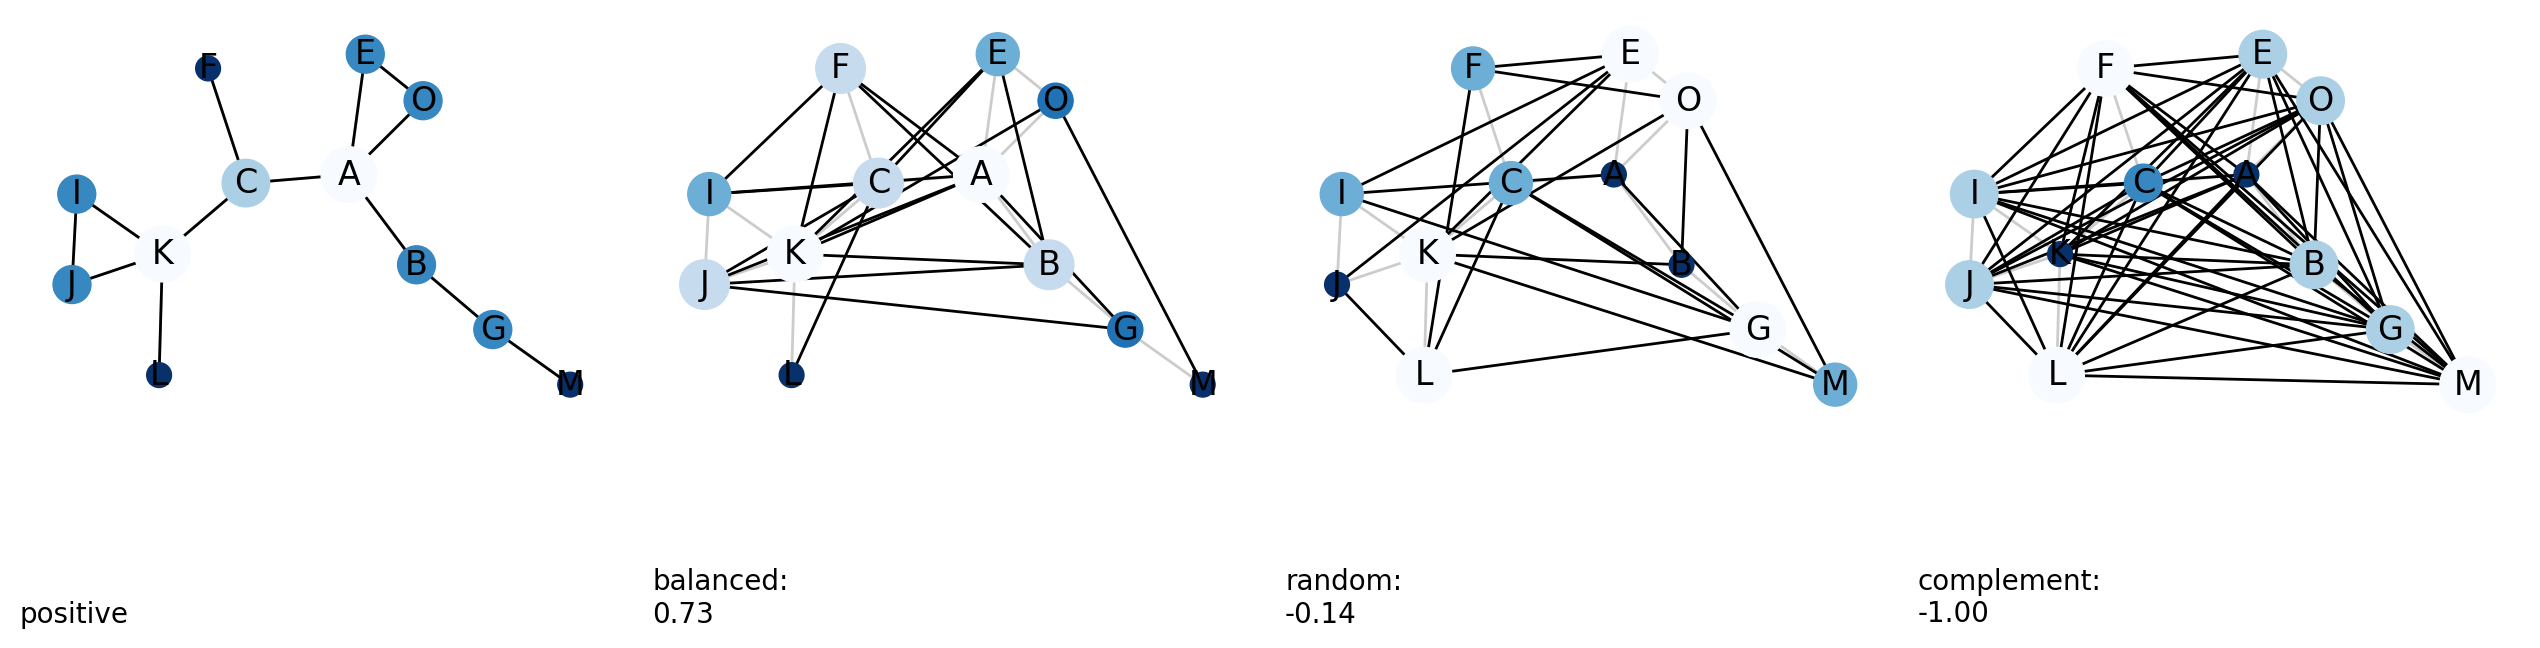

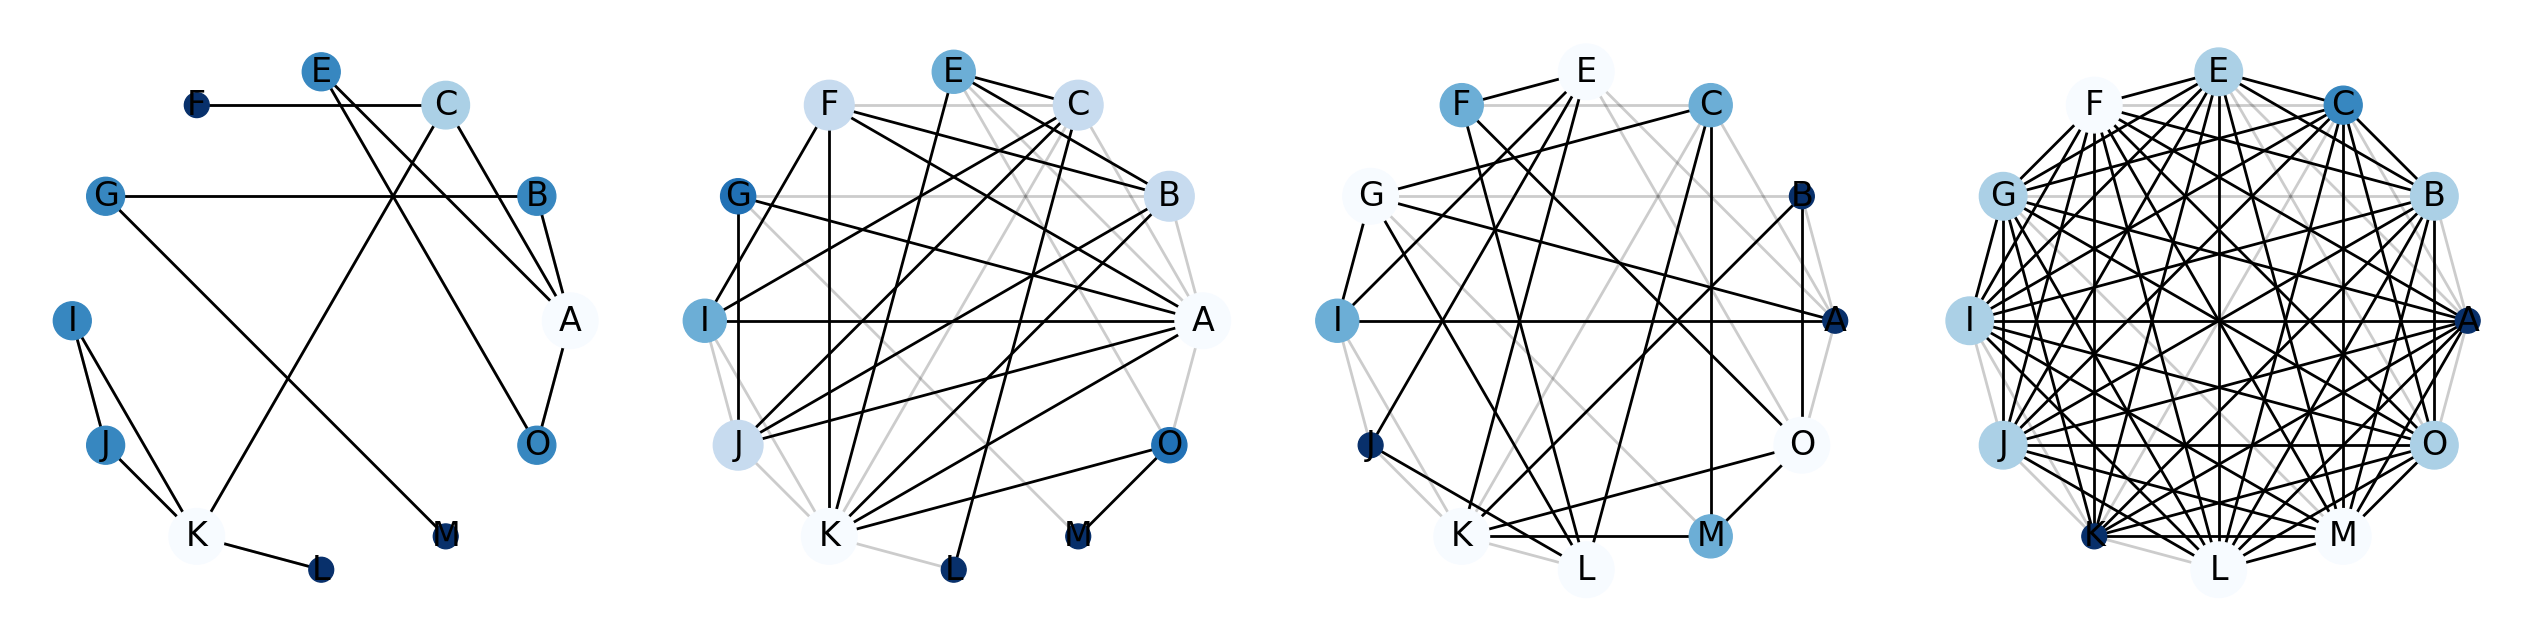

In [13]:
_ = draw_toy_ppis(ppis, ppi_dict)

#### with homodimers

In [14]:
# added F-F
raw = '''A\tB\nA\tC\nC\tF\nA\tE\nK\tL\nC\tK\nB\tG\nG\tM\nA\tO\nE\tO\nI\tJ\nJ\tK\nI\tK\nF\tF'''
ppis = ppis_from_string(raw)

aim for 21 negatives; upper limit is 64
got 21 negatives with bias 0.693
aim for 21 negatives; upper limit is 64
got 21 negatives with bias -0.340
aim for 140 negatives; upper limit is 64
got 64 negatives with bias -1.000


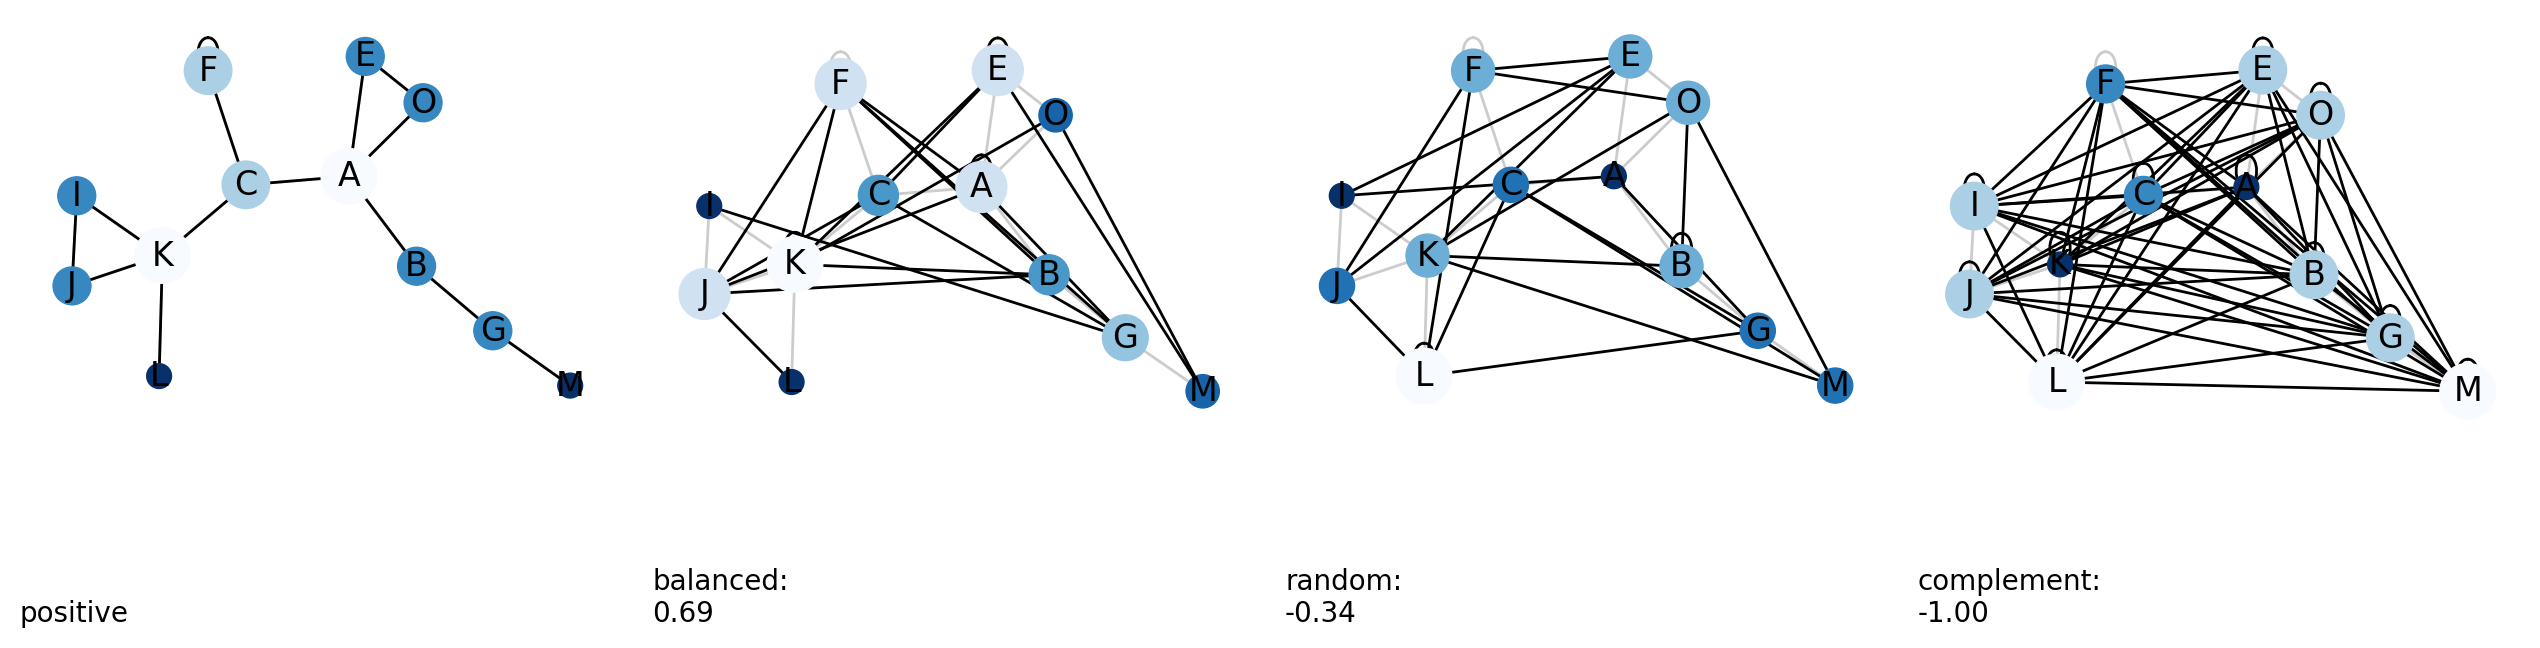

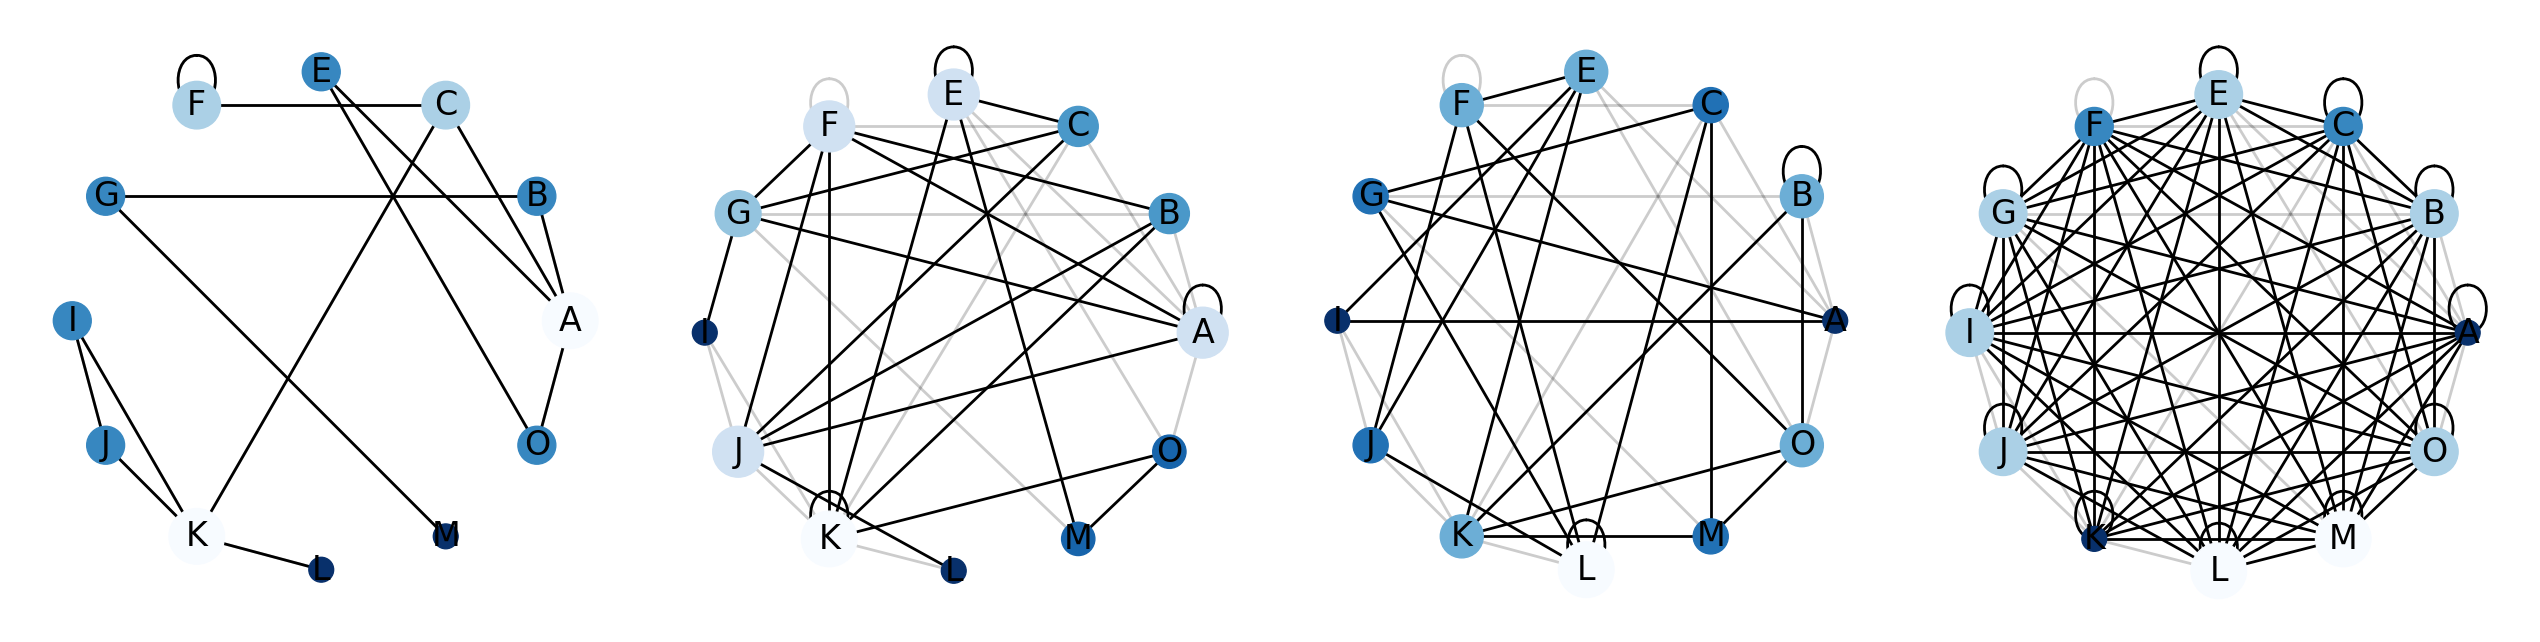

In [15]:
ppi_dict = dict()
ppi_dict['balanced'], _ = find_negative_pairs(ppis, ratio=1.5, seed=42,
                                              strategy=SamplingStrategy.BALANCED)
ppi_dict['random'], _ = find_negative_pairs(ppis, ratio=1.5, seed=42,
                                            strategy=SamplingStrategy.RANDOM)
ppi_dict['complement'], _ = find_negative_pairs(ppis, ratio=10, seed=42,
                                                strategy=SamplingStrategy.BALANCED)
_ = draw_toy_ppis(ppis, ppi_dict)

#### input homodimers, but not allowed as negatives

aim for 21 negatives; upper limit is 53
got 21 negatives with bias 0.601
aim for 21 negatives; upper limit is 53
got 21 negatives with bias 0.000
aim for 140 negatives; upper limit is 53
got 53 negatives with bias -0.837


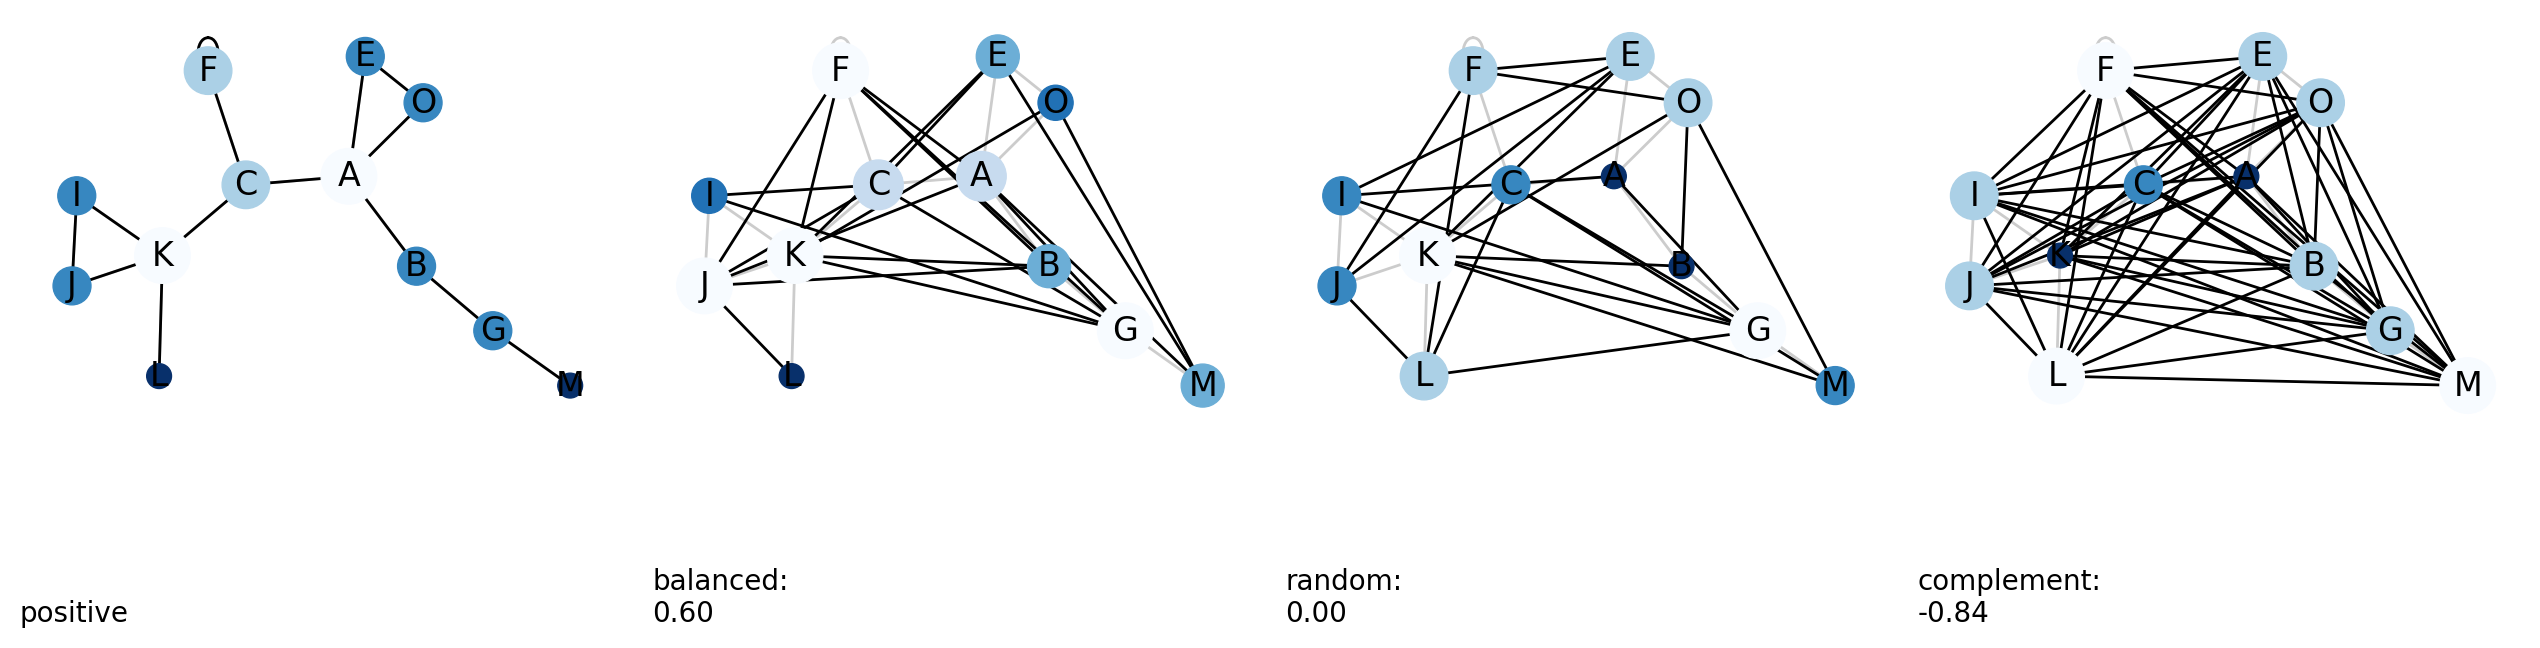

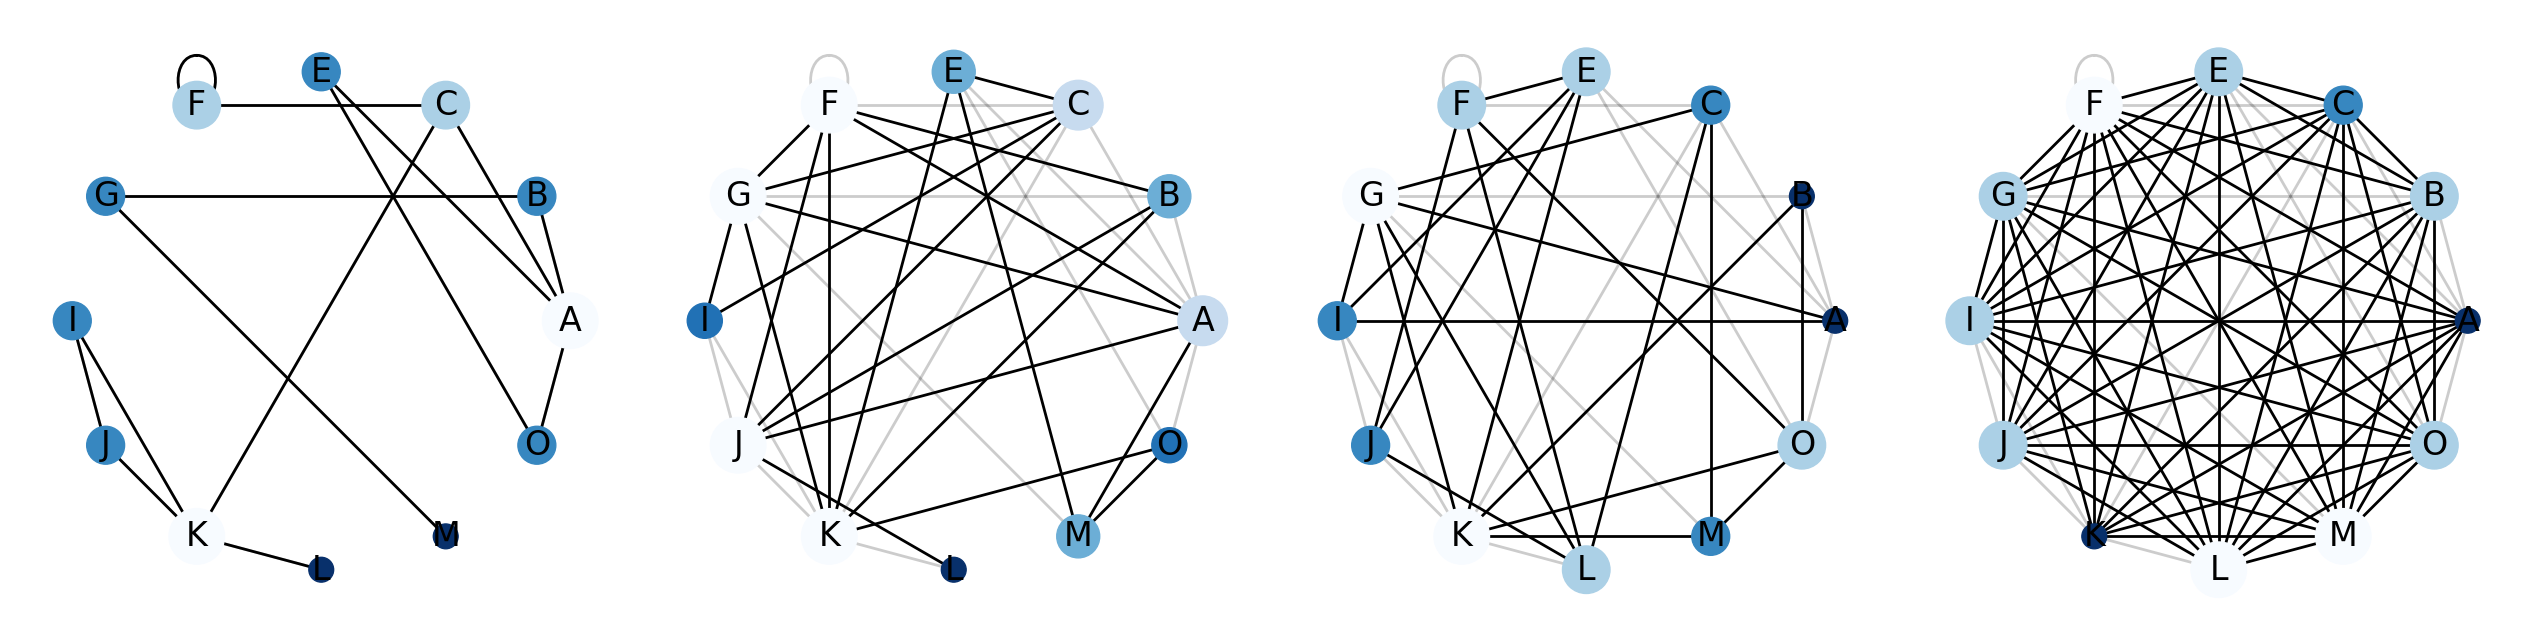

In [16]:
ppi_dict = dict()
ppi_dict['balanced'], _ = find_negative_pairs(ppis, ratio=1.5, seed=42,
                                              strategy=SamplingStrategy.BALANCED,
                                              homodimers=False)
ppi_dict['random'], _ = find_negative_pairs(ppis, ratio=1.5, seed=42,
                                            strategy=SamplingStrategy.RANDOM,
                                            homodimers=False)
ppi_dict['complement'], _ = find_negative_pairs(ppis, ratio=10, seed=42,
                                                strategy=SamplingStrategy.BALANCED,
                                                homodimers=False)
_ = draw_toy_ppis(ppis, ppi_dict)

## Train set: APID
#### extract from `<taxid>*_Q1.txt` files

In [17]:
c.qp = unzip_apid(zip_path='apid.zip', keep_human=c.keep_human,
                  keep_interspecies=c.keep_interspecies)
c.qp

PosixPath('apid_q1')

In [18]:
uniprot_ids = extract_apid_uniprot_ids(c.qp)
len(uniprot_ids)

45026

In [19]:
ppis = extract_apid_ppis(c.qp)
len(ppis)

161598

In [20]:
ppis.head()

,UniprotID_A,UniprotID_B,species
0,Q91572,Q9PTG8,8355
1,P02281,P62799,8355
2,P02281,P84233,8355
3,P02281,Q6AZJ8,8355
4,Q66J96,Q66J96,8355


#### interspecies interactions
Check if there are PPIs (based on UniProt IDs) that occur in several species. We use APID `noISI` data per default, so the exclusion of this data is not implemented.

In [21]:
find_multi_species_ppis = lambda ppi_df: pd.concat(
    [df for i, df in ppi_df.groupby(
        ['UniprotID_A', 'UniprotID_B']) if len(df) > 1]
    + [ppi_df.loc[ppi_df.species == 'is there a marsupilami?']])

find_multi_species_ppis(ppis)

,UniprotID_A,UniprotID_B,species


In [22]:
# proof that actually worked: add some dummy data
for i in [0, 1]:
    s = ppis.iloc[i].copy()
    s.species = 'marsupilami'
    ppis = pd.concat([ppis, pd.DataFrame(s).T], axis=0)

marsu = find_multi_species_ppis(ppis)

# drop the dummy data
ppis = ppis.loc[ppis.species != 'marsupilami']
marsu

,UniprotID_A,UniprotID_B,species
1,P02281,P62799,8355
1,P02281,P62799,marsupilami
0,Q91572,Q9PTG8,8355
0,Q91572,Q9PTG8,marsupilami


or more generally protein IDs that occur in several species:

In [23]:
find_multi_species_proteins(ppis)

,UniprotID,species


#### species lookup

In [24]:
# pick a charismatic animal for validation!
taxonomy = fetch_taxonomic_info(ppis.species)
taxonomy

100%|██████████| 31/31 [00:14<00:00,  2.15it/s]


,species,name,speciesn_ppis
0,632,Yersinia pestis,6
1,1392,Bacillus anthracis,4
2,3702,Arabidopsis thaliana,44723
3,6239,Caenorhabditis elegans,15257
4,7227,Drosophila melanogaster,35493
5,7955,Danio rerio,124
6,8355,Xenopus laevis,49
7,9031,Gallus gallus,40
8,9913,Bos taurus,117
9,9986,Oryctolagus cuniculus,10


#### download sequences

In [25]:
# # if you are re-running this without changes above or deleting files, skip!
# _ = uniprot_api_fetch(uniprot_ids, c.ap / 'apid')

#### map IDs to seq hashes

In [26]:
hash_ppis = ppis_to_hashes(ppis, c.ap / 'apid.json').drop_duplicates()
hash_ppis.head()

,hash_A,hash_B,species
0,CRC-B0BF1F2AA4901439,CRC-EF812949F5B4DE54,8355
1,CRC-A9E5DFD3F8B97598,CRC-DA6C122EC8359FD9,8355
2,CRC-6FD8508EA50A0EEC,CRC-DA6C122EC8359FD9,8355
3,CRC-62E46ABF27FA5E98,CRC-DA6C122EC8359FD9,8355
4,CRC-B9F0CEE49EDB98A1,CRC-B9F0CEE49EDB98A1,8355


In [27]:
len(ppis) - len(hash_ppis)

1030

In [28]:
fasta = SeqIO.to_dict(SeqIO.parse(c.ap / 'apid.hash.fasta', 'fasta'))
len(fasta)

44707

#### filter by seq length

In [29]:
c.min_seq_len, c.max_seq_len

(50, 1500)

dropped 9425/160568 PPIs from length filtering
dropped 0/42505 table IDs and 0/151143 rows, and 2202/44707 sequence IDs


(44707, 42505)

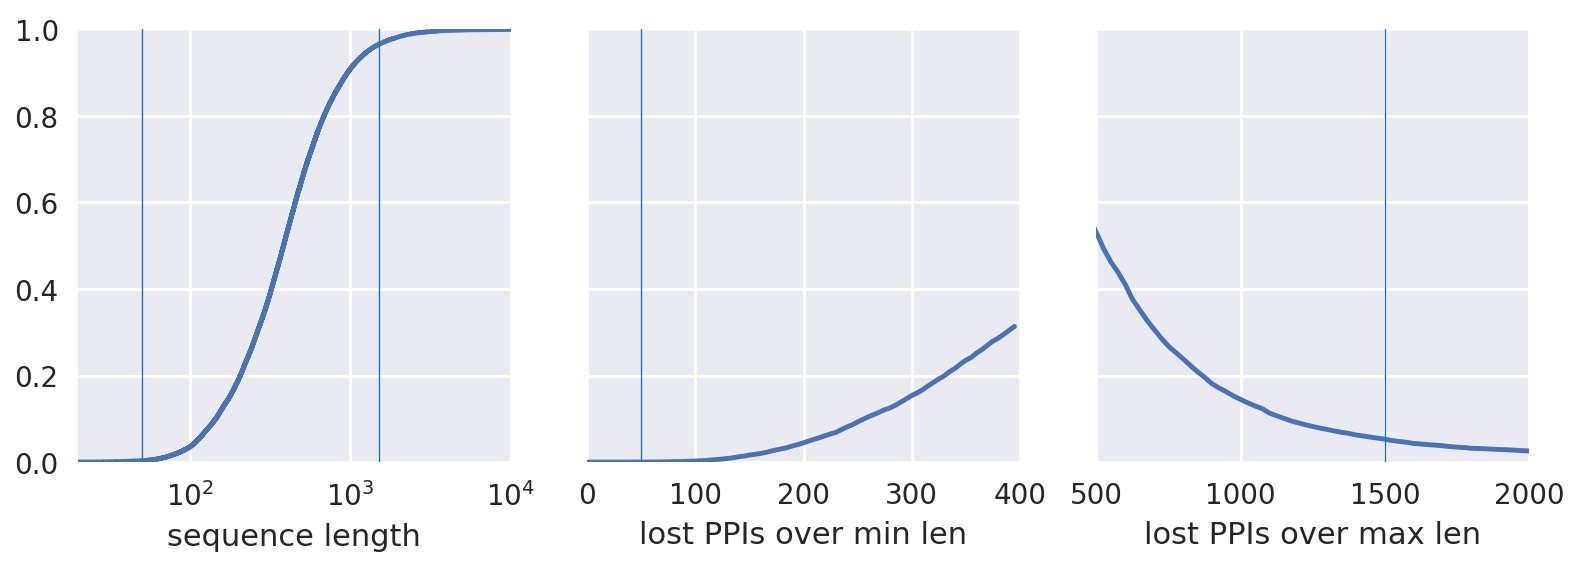

In [30]:
_hash_ppis, _fasta, fig = filter_ppis_and_fasta_by_len(
    hash_ppis, fasta, c.min_seq_len, c.max_seq_len)
len(fasta), len(_fasta)

continue if these limits were ok, or change/set the values for
`cfg.min_seq_len, cfg.max_seq_len` and re-run the filtering cell

In [31]:
hash_ppis = _hash_ppis
fasta = _fasta

#### homodimer share
Overall count, share, overall PPI count

(True, 4249, 0.0281, 151143)

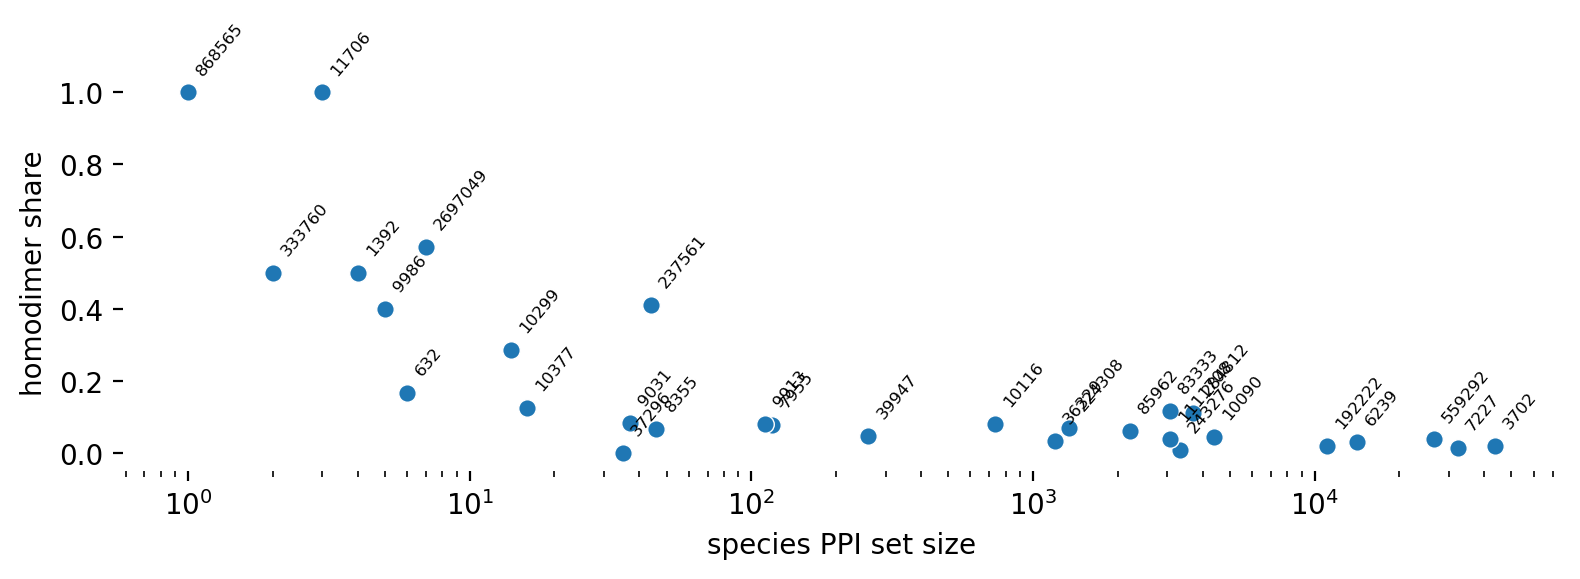

In [32]:
_ = plot_homodimer_share(hash_ppis)
c.keep_homodimers, *count_homodimers(hash_ppis),

In [33]:
if not c.keep_homodimers:
    hash_ppis = drop_homodimers(hash_ppis)
    hash_ppis, fasta = shrink_both_ways(hash_ppis, fasta)
    len(hash_ppis), len(fasta)

## Train set: negatives

In [34]:
c.ratio, c.seed, c.strategy

(10.0, 24, <SamplingStrategy.BALANCED: 1>)

In [35]:
train_ppis, train_negs, train_bias = make_train_negatives(
    hash_ppis, ratio=c.ratio, seed=c.seed, strategy=c.strategy, homodimers=c.keep_homodimers)

sampling negatives per species! aim for 1511430


/home/k/kaindll/anaconda3/envs/ppi/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


1511002 negatives with overall 0.954 and average per-species bias of 0.363±0.865 (std)


In [36]:
train_bias

,species,bias
0,632,-1.0
1,1392,-1.0
2,3702,0.965711
3,6239,0.979152
4,7227,0.987682
5,7955,0.707766
6,8355,0.85258
7,9031,0.853161
8,9913,0.949356
9,9986,-1.0


#### species without negatives or a constant Pearson/Spearman

In [37]:
train_bias.loc[train_bias.bias.isna()]

,species,bias
14,11706,<NA>
27,868565,<NA>


In [38]:
weird_species = set(train_bias.loc[train_bias.bias.isna(), 'species'])
train_ppis.loc[train_ppis['species'].isin(weird_species)]

,hash_A,hash_B,species,label
0,CRC-B74C3858C20EF82C,CRC-B74C3858C20EF82C,11706,1
1,CRC-8487B36BDEAC5FE4,CRC-8487B36BDEAC5FE4,11706,1
2,CRC-4BCF5059C9A7F3B2,CRC-4BCF5059C9A7F3B2,11706,1
0,CRC-69FE9D78A4BB4FEC,CRC-69FE9D78A4BB4FEC,868565,1


In [39]:
train_negs.loc[train_negs['species'].isin(weird_species)]

,hash_A,hash_B,species,label
0,CRC-4BCF5059C9A7F3B2,CRC-8487B36BDEAC5FE4,11706,0
1,CRC-4BCF5059C9A7F3B2,CRC-B74C3858C20EF82C,11706,0
2,CRC-8487B36BDEAC5FE4,CRC-B74C3858C20EF82C,11706,0


This is very little data that we can safely drop. For curiosity's sake:

In [40]:
taxonomy.loc[taxonomy.species.isin(weird_species)]

,species,name,speciesn_ppis
14,11706,HIV-1 M:B_HXB2R,3
28,868565,Human herpesvirus 8 strain GK18,1


It's actually ok to just drop these organisms at this point - no need to backpropagate this farther up.

In [41]:
# actually drop the data here
train_ppis, train_negs, train_bias = [df.loc[~df.species.isin(weird_species)]
                                      for df in (train_ppis, train_negs, train_bias)]
c.weird_species = weird_species
len(train_ppis)

151139

#### set size and bias
This is *before* the extraction of the validation set and therefor preliminary.

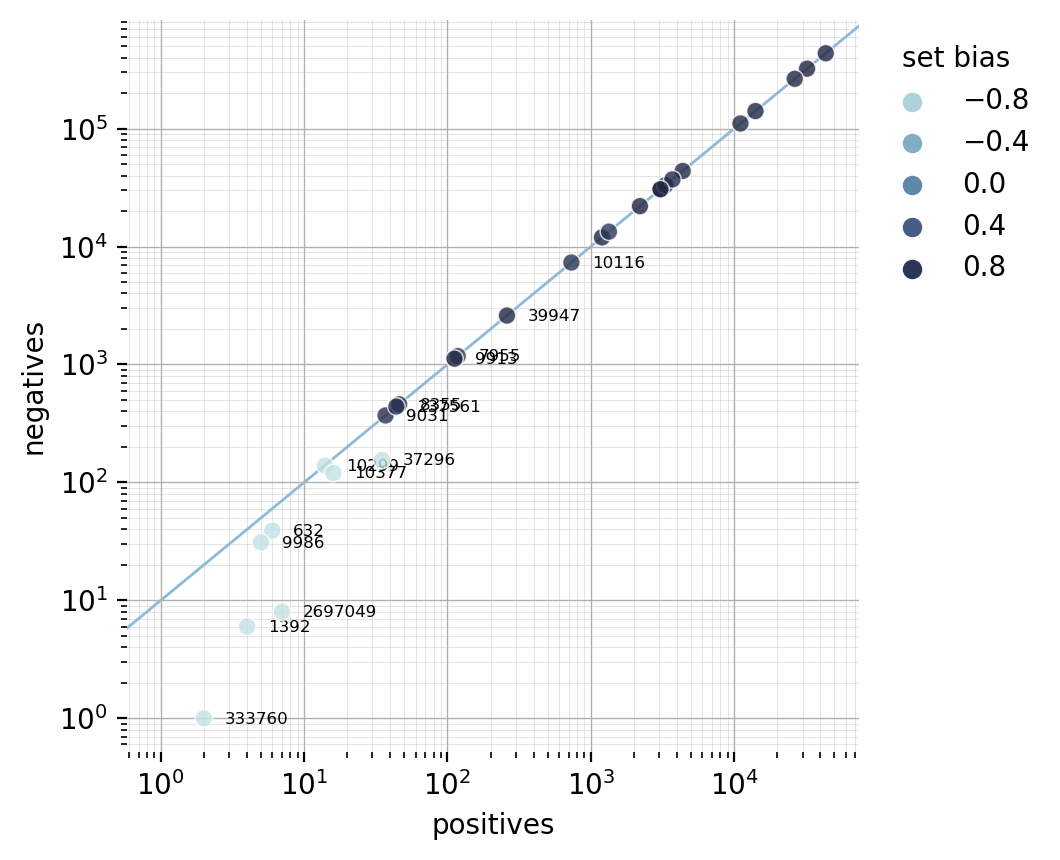

In [42]:
_ = plot_bias(train_ppis, train_negs, train_bias, c.ratio)

## Validation set: APID
#### val: select species/proteins
Either by sampling a subset of proteins and selecting the PPIs or picking the ones for one or more particular species

In [43]:
c.val_set_size, c.val_species

(0.1, {7955, 8355, 9031, 9913, 10116, 10377, 37296, 39947})

In [44]:
# # just a suggestion
# val_species = {7955, 9031, 9913, 10377, 37296, 39947}

In [45]:
train_ppis['label'] = 1
if c.val_species is not None:
    train, val = make_validation_species(train_ppis, c.val_species)
    train_negs = train_negs.loc[~train_negs.species.isin(c.val_species)]
else:
    # if the set becomes too large, try another seed! With this approach, PPIs *will* be lost
    train, val = make_validation_split(train_ppis, c.val_set_size, c.seed)
len(train), len(train) / len(train_ppis), len(val), len(val) / len(train_ppis)

(149783, 0.9910281264266668, 1245, 0.008237450294100133)

In [46]:
val.head()

,hash_A,hash_B,species,label
0,CRC-B0BF1F2AA4901439,CRC-EF812949F5B4DE54,8355,1
1,CRC-A9E5DFD3F8B97598,CRC-DA6C122EC8359FD9,8355,1
3,CRC-62E46ABF27FA5E98,CRC-DA6C122EC8359FD9,8355,1
4,CRC-B9F0CEE49EDB98A1,CRC-B9F0CEE49EDB98A1,8355,1
6,CRC-B58DE4D6485EC347,CRC-CF0C24762765E560,8355,1


In [47]:
val.species.unique()

array([ 8355,  7955,  9913, 10116,  9031, 37296, 39947, 10377])

#### train: select / re-sample negatives
We have already generated negatives above. If we want to use them, we have to drop the negatives with a protein not in the `train` PPIs, then take the rest as training set negatives. But let's also look at the bias of this cropped set! (Resample negatives for `val` later, after redundancy reduction.)

In [48]:
train_proteins = set(np.unique(train.iloc[:, [0, 1]]))
_train_negs = train_negs.loc[(train_negs.hash_A.isin(train_proteins))
                             & (train_negs.hash_B.isin(train_proteins))]
len(_train_negs), len(train_negs), len(_train_negs) / len(train_negs)

(1497674, 1497674, 1.0)

In [49]:
estimate_bias(train, _train_negs, corrtype=CorrelationType.SPEARMAN)

SpearmanrResult(correlation=0.9691911872515412, pvalue=0.0)

In [50]:
estimate_bias(train, _train_negs, corrtype=CorrelationType.PEARSON)

(0.9547541935630359, 0.0)

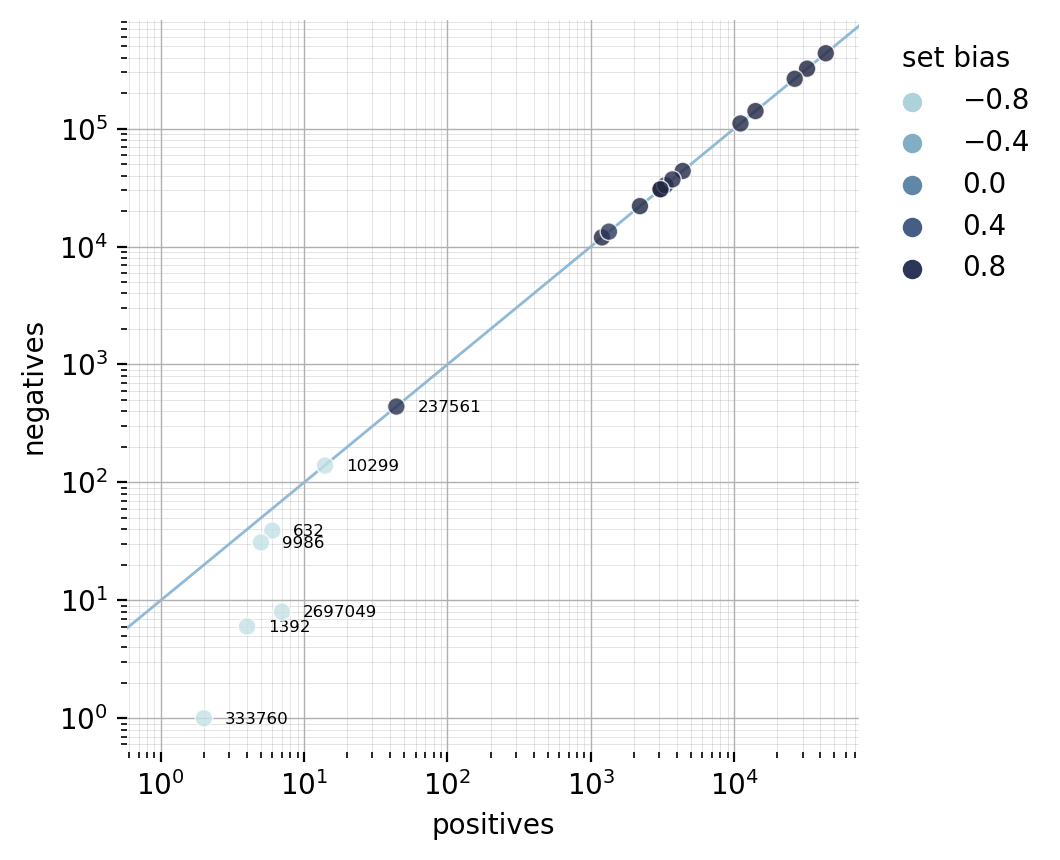

In [51]:
fig = plot_bias(train, _train_negs, train_bias, c.ratio)
fig.savefig('train_bias_0_og.png', transparent=False)

Redraw a set of negative anyway to see if it would fit significantly better:

In [52]:
t_ppis, t_negs, t_bias = make_train_negatives(train, c.strategy, c.ratio, c.seed, c.keep_homodimers)

sampling negatives per species! aim for 1497830
1497674 negatives with overall 0.955 and average per-species bias of 0.351±0.886 (std)


In [53]:
# drop na data
t_ppis = t_ppis.loc[~t_ppis.species.isin(t_bias.loc[t_bias.bias.isna()].species)]

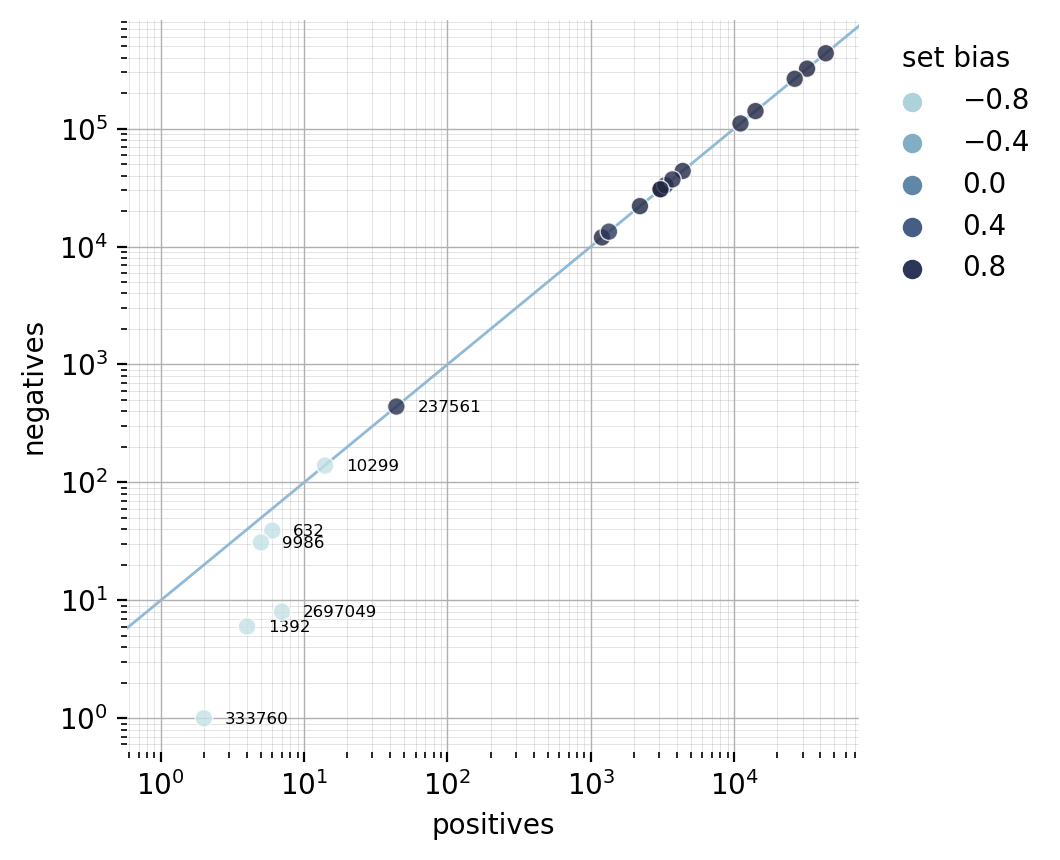

In [54]:
fig = plot_bias(t_ppis, t_negs, t_bias, c.ratio)
fig.savefig('train_bias_1_resample.png', transparent=False)

In [55]:
# pick one!
picked_idx = 1
train_all = [pd.concat((train, _train_negs)), pd.concat((t_ppis, t_negs))][picked_idx]
c.train_bias = [train_bias.to_json(), t_bias.to_json()][picked_idx]
len(train_all)

1647457

Separate the validation set sequences from the ones remaining as train set

In [56]:
_, train_seqs = shrink_both_ways(train_all.copy(), fasta.copy())
c.train_seqs = len(train_seqs)
len(train_seqs), len(fasta)

dropped 0/41244 table IDs and 0/1647457 rows, and 1261/42505 sequence IDs


(41244, 42505)

#### train: save


In [57]:
_ = SeqIO.write(values_sorted_by_key(train_seqs), c.train_fasta, 'fasta')
train_all.to_csv(c.train_tsv, sep='\t', header=True, index=False)
c.train_size = len(train_all)
c.train_fasta, c.train_tsv

(PosixPath('apid_train.fasta'), PosixPath('apid_train.tsv'))

#### val: save

In [58]:
_, val_seqs = shrink_both_ways(val.copy(), fasta.copy())
len(val_seqs), len(fasta)

dropped 0/1235 table IDs and 0/1245 rows, and 41270/42505 sequence IDs


(1235, 42505)

Mind that the TSV will contain only positives! Sample negatives only after the whole `uniqueprot`-shebang.

In [59]:
_ = SeqIO.write(values_sorted_by_key(val_seqs), c.val_raw_fasta, 'fasta')
val.to_csv(c.val_raw_tsv, sep='\t', header=True, index=False)
c.val_raw_fasta, c.val_raw_tsv

(PosixPath('apid_sequences/apid_validation_raw.fasta'),
 PosixPath('apid_sequences/apid_validation_raw.tsv'))

## Test set: HuRI
#### download and extract PPIs

In [60]:
c.psi_path

PosixPath('hi_union.psi')

In [61]:
# it's somehow a lot faster to download this from a browser!
# or run !wget "http://www.interactome-atlas.org/data/HI-union.psi" -O "hi_union.psi"
download_y2h_interactome(c.psi_path)

already downloaded and SHA256 checks out


PosixPath('hi_union.psi')

In [62]:
huri_ppis, huri_seq_ids = extract_huri_ppis(c.psi_path)
len(huri_ppis)

97888

In [63]:
huri_seqs, _ = fetch_huri_seqs(huri_seq_ids, c.hp / 'huri')
len(huri_seqs)

loading from huri_sequences/huri.hash.fasta and huri_sequences/huri.json


9119

#### map + filter PPIs

In [64]:
print(set(huri_ppis.species))  # only human, but keep the label
huri_ppis.head()

{9606}


,0,1,species
0,P0DP25,A0A087WXN0,9606
1,Q68D86-1,Q9HD26-2,9606
2,Q13515,Q9UJW9,9606
3,P30049,Q05519-2,9606
4,ENSP00000462298,P43220,9606


In [65]:
huri_hash_ppis = ppis_to_hashes(huri_ppis, c.hp / 'huri.json')
len(huri_ppis) - len(huri_hash_ppis)

35329

In [66]:
huri_hash_ppis = remove_ids_from(huri_hash_ppis, black_list_fasta=c.train_fasta)
len(huri_hash_ppis)

61162

In [67]:
*count_homodimers(huri_hash_ppis), c.keep_homodimers

(751, 0.0123, 61162, True)

In [68]:
if not c.keep_homodimers:
    huri_hash_ppis = drop_homodimers(huri_hash_ppis)
    huri_hash_ppis, huri_seqs = shrink_both_ways(huri_hash_ppis, huri_seqs)
    len(huri_hash_ppis), len(huri_seqs)

dropped 1208/61162 PPIs from length filtering
dropped 0/8805 table IDs and 0/59954 rows, and 314/9119 sequence IDs


(9119, 8805)

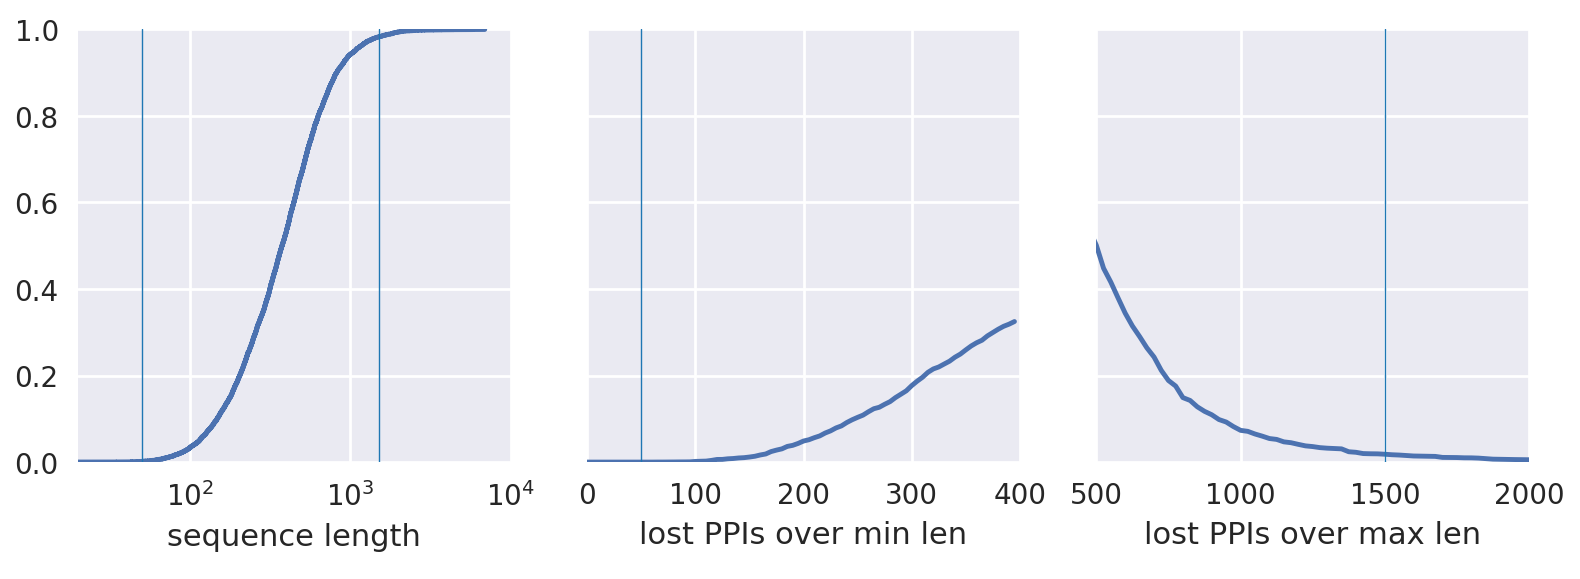

In [69]:
_huri_hash_ppis, _huri_seqs, fig = filter_ppis_and_fasta_by_len(
    huri_hash_ppis, huri_seqs, c.min_seq_len, c.max_seq_len)
len(huri_seqs), len(_huri_seqs)

#### save to files

In [70]:
huri_hash_ppis = _huri_hash_ppis
huri_seqs = _huri_seqs
_ = SeqIO.write(huri_seqs.values(), c.test_raw_fasta, 'fasta')
huri_hash_ppis.to_csv(c.test_raw_tsv, sep='\t', header=True, index=False)
c.test_raw_fasta, c.test_raw_tsv

(PosixPath('huri_sequences/huri_test_raw.fasta'),
 PosixPath('huri_sequences/huri_test_raw.tsv'))

## Redundancy Reduction with [rostclust](https://git.rostlab.org/bernhoferm/mmseqs2-uniqueprot/-/tree/F_typer_app)

**Don't run the next cells in the wrong order, and don't forget to copy the files back and forth if you are running `rostclust` elsewhere! <br>In particular, copy files after `shrink_files_both_ways`. Was that name not clear?**

In [71]:
c.hval_config

{'shortAlignmentLen': 50,
 'longSeqLen': 180,
 'reduceRandomAlign': False,
 'clusterThreshold': 20}

#### redundancy-reduce test and validation
The flag below allows me to test this notebook without the MMseqs2 runs. Leave `rostclust_pretend` at `True` and copy the two result files to this folder; or run `rostclust uniqueprot[2D]` now and here.

In [72]:
c.rostclust_pretend

False

In [73]:
if c.rostclust_pretend:
    !rsync -zar -e ssh "." "kaindll@lapislazuli:/home/k/kaindll/ppi/data/ppi_dataset"

In [74]:
# redundancy-reduce the test set
run_uniqueprot(c.test_raw_fasta, c.test_rr_fasta, c.hval_config, pretend=c.rostclust_pretend)

In [75]:
# and validation
run_uniqueprot(c.val_raw_fasta, c.val_rr_fasta, c.hval_config, pretend=c.rostclust_pretend)

In [76]:
if c.rostclust_pretend:
    !rsync -zar -e ssh "kaindll@lapislazuli:/home/k/kaindll/ppi/data/ppi_dataset/" "."

In [77]:
fastalen = lambda _file: len([r.id for r in SeqIO.parse(_file, 'fasta')])

In [78]:
# also drop PPIs accordingly
assert c.test_rr_fasta.is_file()
shrink_files_both_ways(c.test_raw_tsv, c.test_rr_fasta,
                       new_tsv_name=c.test_rr_tsv,
                       new_fasta_name=c.test_fasta)  # finished!
c.test_seqs = fastalen(c.test_fasta)
assert c.val_rr_fasta.is_file()
shrink_files_both_ways(c.val_raw_tsv, c.val_rr_fasta,
                       new_tsv_name=c.val_rr_tsv,
                       new_fasta_name=c.val_fasta)  # finished!
c.val_seqs = fastalen(c.val_fasta)

dropped 2875/8805 table IDs and 36387/59954 rows, and 749/5930 sequence IDs
dropped 376/1235 table IDs and 670/1245 rows, and 186/859 sequence IDs


In [79]:
if c.rostclust_pretend:
    !rsync -zar -e ssh "." "kaindll@lapislazuli:/home/k/kaindll/ppi/data/ppi_dataset"

#### cluster `test` and `val` against `train`

First, cluster the `HuRI` test set against the `APID` train set to get **C1-3** labels for the final test PPIs. Then, cluster the `APID` validation set against the `APID` train set, which gives us **C1-3** labels for the validation set.

In [80]:
run_uniqueprot2D(c.test_fasta, c.train_fasta, c.test_c3_fasta,
                 hval_config=c.hval_config, pretend=c.rostclust_pretend)

In [81]:
run_uniqueprot2D(c.val_fasta, c.train_fasta, c.val_c3_fasta,
                 hval_config=c.hval_config, pretend=c.rostclust_pretend)

In [82]:
if c.rostclust_pretend:
    !rsync -zar -e ssh "kaindll@lapislazuli:/home/k/kaindll/ppi/data/ppi_dataset/" "."

In [83]:
assert c.test_c3_fasta.is_file()
assert c.val_c3_fasta.is_file()

## Generate negatives

Negatives are sampled *per species*. Mind that the test set is human-only!
Also, identify and assign **C1/C2/C3** class labels at this point.

In [84]:
c.ratio, c.seed, c.strategy

(10.0, 24, <SamplingStrategy.BALANCED: 1>)

#### APID val: generate & classify

In [85]:
# sanity check if there are any proteins in test that
# were already in train. re: "do not add back in identical ones"
assert not ({r.id for r in SeqIO.parse(c.train_fasta, 'fasta')} & {
    r.id for r in SeqIO.parse(c.test_fasta, 'fasta')})

In [86]:
for p in [c.val_rr_tsv, c.val_c3_fasta, c.val_fasta]:
    assert p.is_file(), f'missing {p}'

In [87]:
val_ppis, val_negatives, val_bias = make_test_negatives(
    c.val_rr_tsv, c.val_c3_fasta, c.val_fasta, c.strategy,
    c.ratio, c.seed, c.keep_homodimers)
c.val_bias = str(val_bias) if type(val_bias) == np.float64 else val_bias.to_json()
val_negatives.head()

apid_validation.fasta
sampling negatives per species! aim for 5750
5550 negatives with overall 0.800 and average per-species bias of 0.320±0.771 (std)
575


,hash_A,hash_B,species,cclass,label
0,CRC-15DB9BA5BD96EBB7,CRC-3C5E4EDDF27EACFF,7955,2,0
1,CRC-15DB9BA5BD96EBB7,CRC-92D3406E4974E07F,7955,3,0
2,CRC-15DB9BA5BD96EBB7,CRC-F8C0FFFA169927F4,7955,3,0
3,CRC-19A06BD01E209728,CRC-9C4114B04FBD0013,7955,1,0
4,CRC-19A06BD01E209728,CRC-D7F3BC437B9CC698,7955,1,0


In [88]:
val_ppis.head()

,hash_A,hash_B,species,label,cclass
0,CRC-B0BF1F2AA4901439,CRC-EF812949F5B4DE54,8355,1,1
1,CRC-B9F0CEE49EDB98A1,CRC-B9F0CEE49EDB98A1,8355,1,1
2,CRC-09946ABF27FA52A9,CRC-A9E5DFD3F8B97598,8355,1,1
3,CRC-09946ABF27FA52A9,CRC-FE1B7E45DBBC7D95,8355,1,1
4,CRC-5850F23101F38618,CRC-68DDD391C21AC8D6,8355,1,2


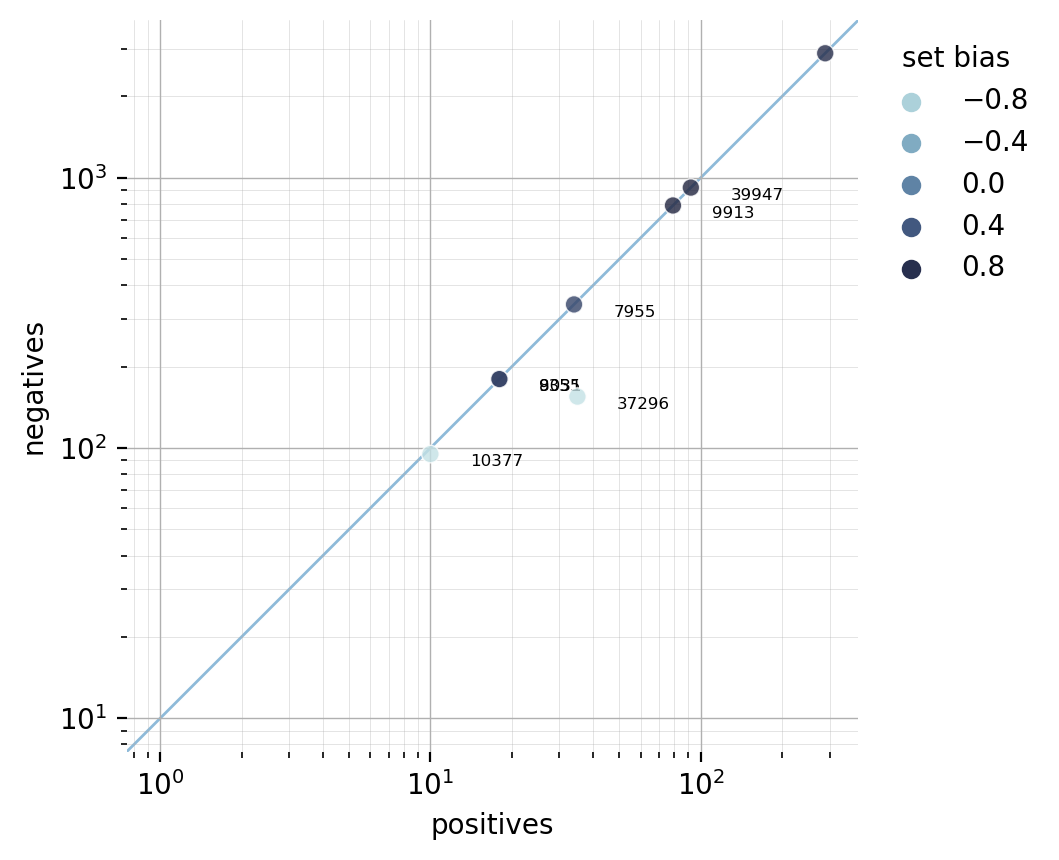

In [89]:
if type(val_bias) != np.float64:
    fig = plot_bias(val_ppis, val_negatives, val_bias, c.ratio)
    fig.savefig('val_bias.png', transparent=False)

In [90]:
val_all = pd.concat([val_ppis, val_negatives])
c.val_size = len(val_all)
len(val_all)

6125

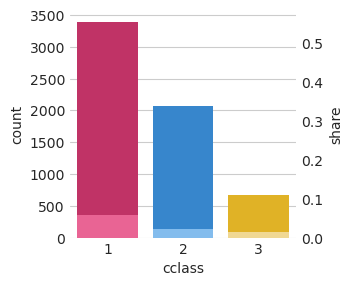

In [91]:
with mpl.rc_context({'figure.dpi': 100}):
    fig = plot_c_classes(val_all)
    c.val_sizes = val_all[['cclass', 'label']].value_counts().to_json()
    fig.savefig('val_cclasses.png', transparent=False)

In [92]:
# have a direct look at the (ranked) degrees, but only for some species
n_degrees_per_sp = fetch_degrees(val_all).groupby('species')[
    'x'].size().sort_values(ascending=False)
# pick two larger and two smaller species sets
sps = list(n_degrees_per_sp.index)[:2] + list(n_degrees_per_sp.index)[-5:-3]
print(sps)
n_degrees_per_sp

[10116, 39947, 7955, 9031]


species
10116    1046
39947     353
9913      247
7955      131
9031       84
8355       82
37296      40
10377      28
Name: x, dtype: int64

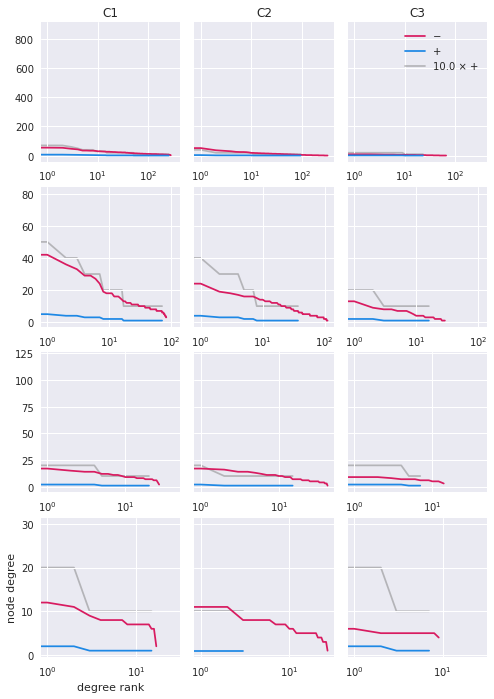

In [93]:
with mpl.rc_context({'figure.dpi': 72 if len(sps) > 2 else 200}):
    # can't unFUBAR the axis limits ...
    fig = plot_test_degrees(val_all.loc[val_all.species.isin(sps)], c.ratio, flip=False)
    fig.savefig('val_degrees.png', transparent=False)

#### APID val: save TSV
The `FASTA` was finalized already, right after the redundancy reduction and before clustering against `train`.

In [94]:
val_all.to_csv(c.val_tsv, sep='\t', header=True, index=False)
c.val_tsv

PosixPath('apid_validation.tsv')

#### HuRI test: generate & classify

In [95]:
for p in [c.test_rr_tsv, c.test_c3_fasta, c.test_fasta]:
    assert p.is_file(), f'missing {p}'

In [96]:
test_ppis, test_negatives, test_bias = make_test_negatives(
    c.test_rr_tsv, c.test_c3_fasta, c.test_fasta, c.strategy,
    c.ratio, c.seed, c.keep_homodimers)
c.test_bias = test_bias
test_negatives.head()

huri_test.fasta
aim for 235670 negatives; upper limit is 13400404
got 235670 negatives with bias 0.976
23567


,hash_A,hash_B,species,cclass,label
0,CRC-000624825E507385,CRC-182BDB421BE2D3AA,9606,2,0
1,CRC-000624825E507385,CRC-9C0E64DB7D0343DF,9606,3,0
2,CRC-000624825E507385,CRC-C1A4890B243C7AEF,9606,3,0
3,CRC-0012F055C7F2A233,CRC-BB5C94131F5B5426,9606,3,0
4,CRC-001576EA78C61C85,CRC-00A839AA4AEC48BC,9606,3,0


In [97]:
test_ppis.head()

,hash_A,hash_B,species,cclass,label
0,CRC-450D36A80D6D88C8,CRC-8A19DDC376DCD0F4,9606,1,1
1,CRC-4CB899386D443FEA,CRC-9C54AFA126F17AF1,9606,2,1
2,CRC-1211E96DDC0A3182,CRC-B7F0D1D01ADFDFE7,9606,1,1
3,CRC-23F4C21E7327DE3D,CRC-8E2B9CB2B8FB72AD,9606,3,1
4,CRC-79AE0E5DF5488CA1,CRC-EA627A87958B83B6,9606,2,1


In [98]:
test_all = pd.concat([test_ppis, test_negatives])
c.test_size = len(test_all)
len(test_all)

259237

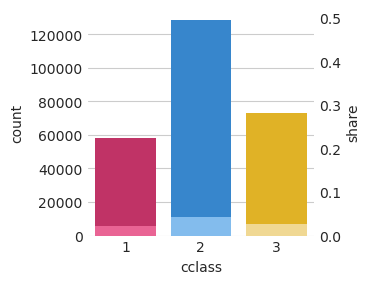

In [99]:
with mpl.rc_context({'figure.dpi': 100}):
    fig = plot_c_classes(test_all)
    c.test_sizes = test_all[['cclass', 'label']].value_counts().to_json()
    fig.savefig('test_cclasses.png', transparent=False)

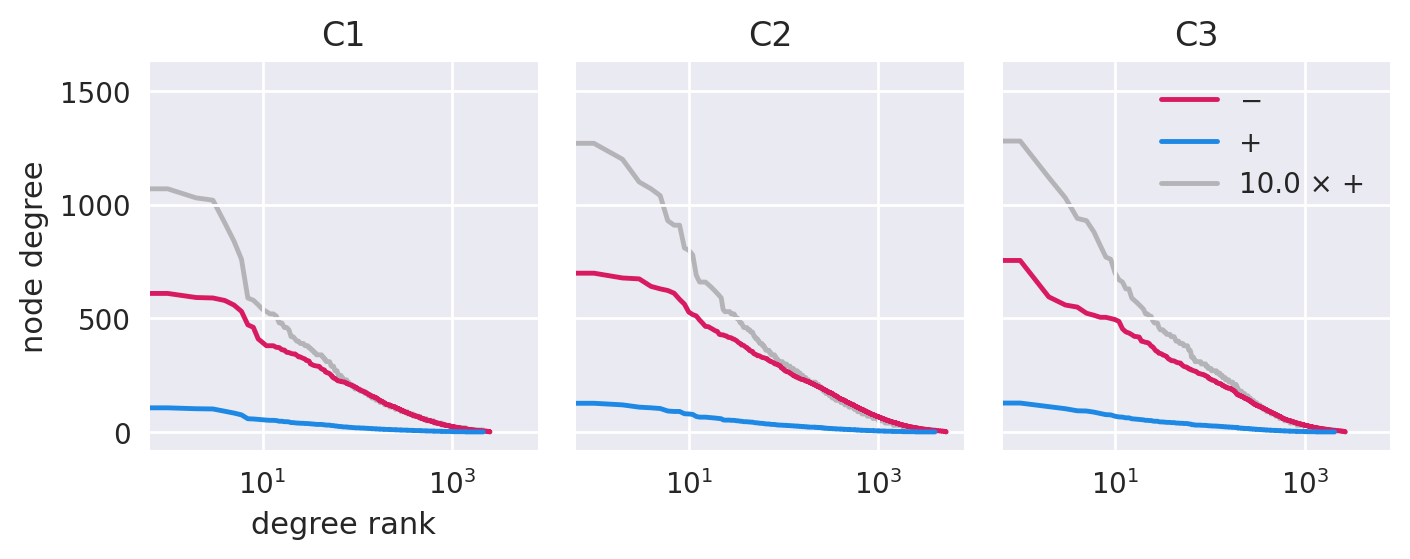

In [100]:
fig = plot_test_degrees(test_all, c.ratio)
fig.savefig('test_degrees.png', transparent=False)

#### HuRI test: save TSV

In [101]:
test_all.to_csv(c.test_tsv, sep='\t', header=True, index=False)
c.test_tsv

PosixPath('huri_test.tsv')

---

In [102]:
with Path(f'cfg.json').open('w') as json_file:
    json_file.write(c.to_json(indent=2))
print(c.to_json(indent=2))

{
  "keep_human": false,
  "keep_interspecies": false,
  "keep_homodimers": true,
  "rostclust_pretend": false,
  "ap": "apid_sequences",
  "hp": "huri_sequences",
  "qp": "apid_q1",
  "min_seq_len": 50,
  "max_seq_len": 1500,
  "hval_config": {
    "shortAlignmentLen": 50,
    "longSeqLen": 180,
    "reduceRandomAlign": false,
    "clusterThreshold": 20
  },
  "seed": 24,
  "ratio": 10.0,
  "strategy": 1,
  "val_set_size": 0.1,
  "val_species": [
    8355,
    10116,
    9031,
    10377,
    39947,
    37296,
    7955,
    9913
  ],
  "val_raw_fasta": "apid_sequences/apid_validation_raw.fasta",
  "val_raw_tsv": "apid_sequences/apid_validation_raw.tsv",
  "val_rr_fasta": "apid_sequences/apid_validation_rr.fasta",
  "val_rr_tsv": "apid_sequences/apid_validation_rr.tsv",
  "val_c3_fasta": "apid_sequences/apid_validation_c3.fasta",
  "val_fasta": "apid_validation.fasta",
  "val_tsv": "apid_validation.tsv",
  "test_raw_fasta": "huri_sequences/huri_test_raw.fasta",
  "test_raw_tsv": "huri_s